# Project 2: S&P 500 Stocks

##### Jimmy Ng & Corey Arnouts

Oct 10, 2020


This is a dataset that contains 503 (out of 505) stocks from the S&P500. This dataset contains 21 trading days (covering the entire September 2020). The direction of "Up" means that the close price went up more than 3% than previous close price, whereas "Down" means that it went to the opposite direction of losing more than 3%. All else are considered the "Same". For simplicity, we only look at "Up" trend in this project.

https://www.youtube.com/watch?v=O_vxdeoEQrQ&feature=youtu.be&ab_channel=CoreyArnouts

In [1]:
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance
import warnings
from pyvis import network as net

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
print(nx.__version__)


1.11


## Import data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/myvioletrose/data620_team/master/project/project_2/sp500_Sep2020.csv", 
                 encoding = "cp1252")    

In [4]:
df

,symbol,datekey,close,previous_close,percent_diff,direction,company_name,sector
0,A,d1,101.120003,100.419998,0.0070,Same,Agilent Technologies Inc,Health Care
1,A,d2,103.419998,101.120003,0.0227,Same,Agilent Technologies Inc,Health Care
2,A,d3,99.639999,103.419998,-0.0365,Down,Agilent Technologies Inc,Health Care
3,A,d4,96.839996,99.639999,-0.0281,Same,Agilent Technologies Inc,Health Care
4,A,d8,95.139999,96.839996,-0.0176,Same,Agilent Technologies Inc,Health Care
...,...,...,...,...,...,...,...,...
10558,ZTS,d24,157.979996,159.330002,-0.0085,Same,Zoetis,Health Care
10559,ZTS,d25,160.839996,157.979996,0.0181,Same,Zoetis,Health Care
10560,ZTS,d28,161.320007,160.839996,0.0030,Same,Zoetis,Health Care
10561,ZTS,d29,162.479996,161.320007,0.0072,Same,Zoetis,Health Care


In [5]:
print("there are {x} number of stocks".format(x = len(df.symbol.unique())))
print("there are {x} trading days in September 2020".format(x = len(df.datekey.unique())))

there are 503 number of stocks
there are 21 trading days in September 2020


## Up-trend

In [6]:
date_count = pd.DataFrame({'date_count' : df[df["direction"] == "Up"].groupby(['symbol']).size()}).\
sort_values(by = ['date_count', 'symbol'], ascending = [False, True]).\
reset_index()

date_count

,symbol,date_count
0,PVH,7
1,DFS,6
2,IVZ,6
3,LEN,6
4,UA,6
...,...,...
328,XOM,1
329,XRAY,1
330,XRX,1
331,XYL,1


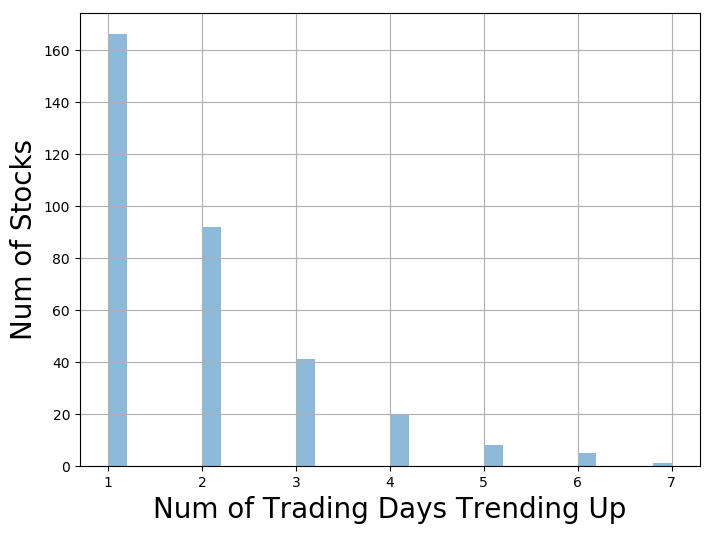

In [7]:
fig = plt.figure(figsize = (8, 6), dpi = 100, facecolor = 'w', edgecolor = 'k')
date_count.iloc[:,1].plot.hist(alpha = 0.5, bins = 30)
plt.xlabel('Num of Trading Days Trending Up', fontsize = 20)
plt.ylabel('Num of Stocks', fontsize = 20)
plt.grid(True)
plt.show() 

## Down-trend

In [8]:
date_count2 = pd.DataFrame({'date_count' : df[df["direction"] == "Down"].groupby(['symbol']).size()}).\
sort_values(by = ['date_count', 'symbol'], ascending = [False, True]).\
reset_index()

date_count2

,symbol,date_count
0,APA,7
1,COTY,7
2,MRO,7
3,DISH,6
4,DXC,6
...,...,...
410,XOM,1
411,XRX,1
412,YUM,1
413,ZBH,1


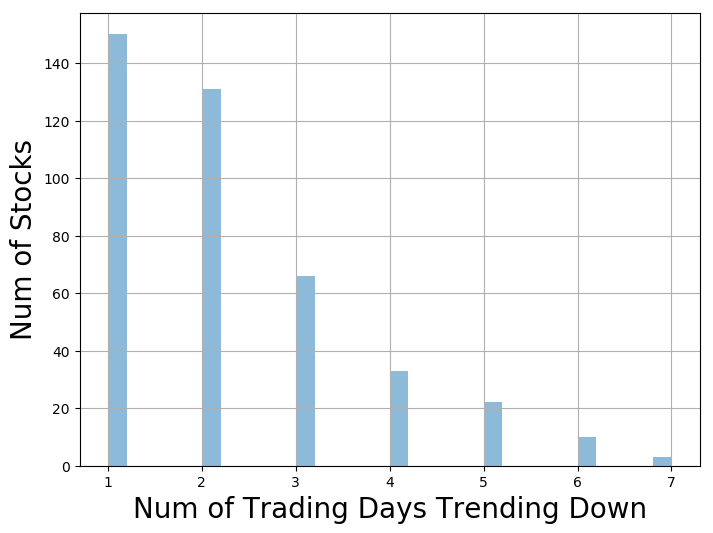

In [9]:
fig = plt.figure(figsize = (8, 6), dpi = 100, facecolor = 'w', edgecolor = 'k')
date_count2.iloc[:,1].plot.hist(alpha = 0.5, bins = 30)
plt.xlabel('Num of Trading Days Trending Down', fontsize = 20)
plt.ylabel('Num of Stocks', fontsize = 20)
plt.grid(True)
plt.show() 

## Clean up df

In [10]:
dfClean = df[df["direction"] == "Up"][["symbol", "datekey", "direction", "sector"]].reset_index(drop = True)

In [11]:
dfClean

,symbol,datekey,direction,sector
0,AAL,d16,Up,Industrials
1,AAL,d25,Up,Industrials
2,AAL,d28,Up,Industrials
3,AAPL,d1,Up,Information Technology
4,AAPL,d9,Up,Information Technology
...,...,...,...,...
625,XRX,d28,Up,Information Technology
626,XYL,d11,Up,Industrials
627,ZION,d4,Up,Financials
628,ZION,d28,Up,Financials


## Draw bipartite graph

In [12]:
G = nx.Graph()

# add symbol nodes
for i in range(len(dfClean)): 
    G.add_node(dfClean.iloc[i][0],
               direction = dfClean.iloc[i][2],
               sector = dfClean.iloc[i][3],
               bipartite = 1)

# add datekey nodes
for i in range(len(dfClean)): 
    G.add_node(dfClean.iloc[i][1],
               bipartite = 0)

# add edges
for i in range(len(dfClean)):
    G.add_edge(dfClean.iloc[i][0], dfClean.iloc[i][1], weight = 1)

nx.is_bipartite(G)    

True

In [13]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 354
Number of edges: 630
Average degree:   3.5593


In [14]:
# symbol_nodes, datekey_nodes
symbol_nodes = [node for node in G.nodes() if G.node[node]['bipartite'] == 1]
datekey_nodes = [node for node in G.nodes() if G.node[node]['bipartite'] == 0]

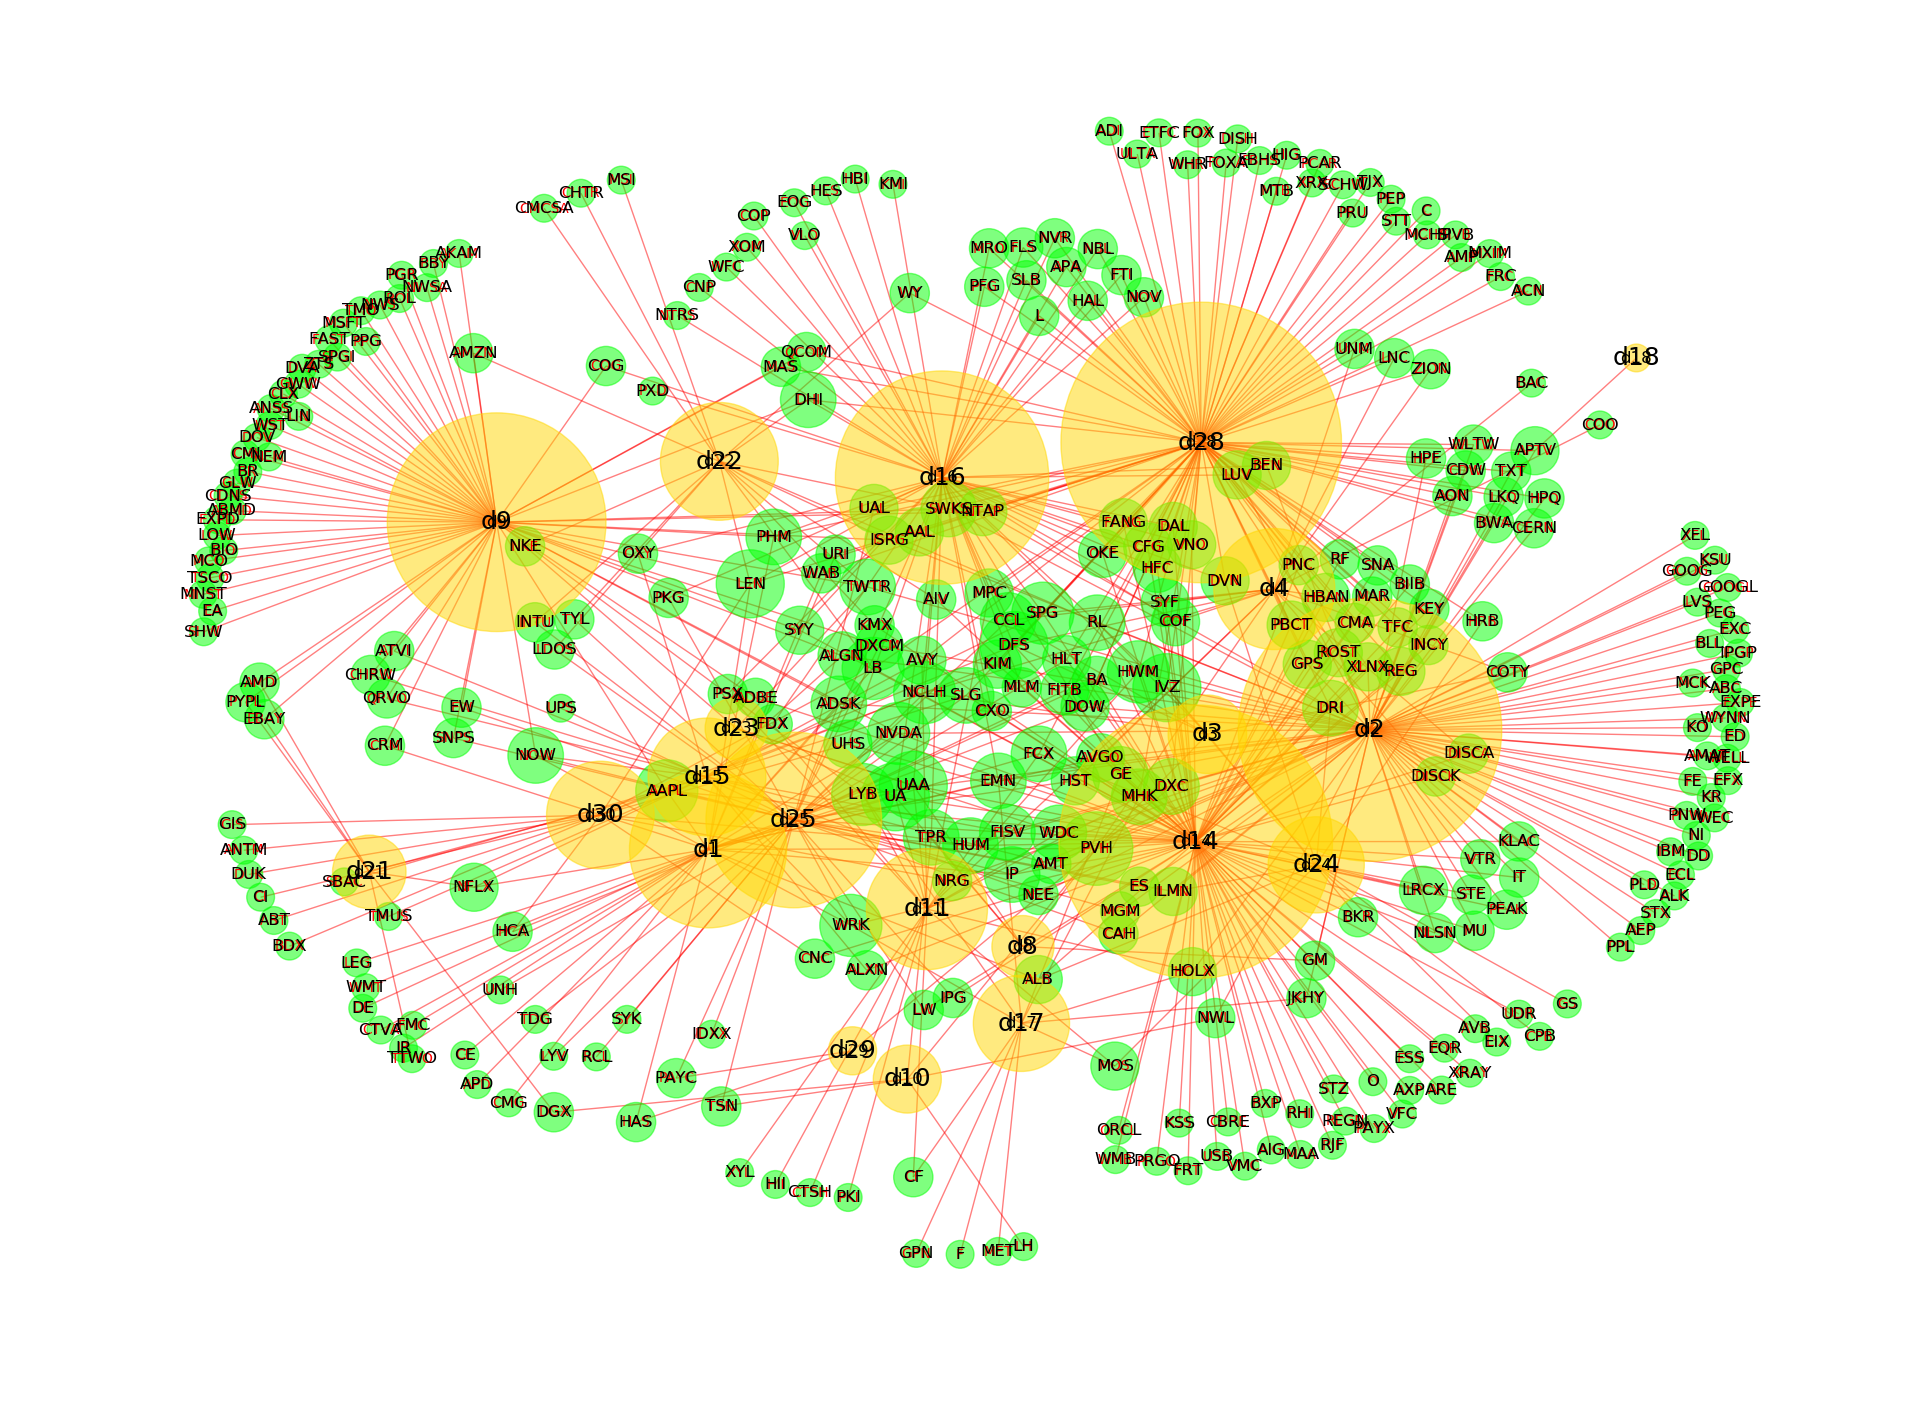

In [15]:
fig = plt.figure(figsize = (24, 18), dpi = 100, facecolor = 'w', edgecolor = 'k')

pos = nx.fruchterman_reingold_layout(G) 

colors=[]
        
symbol_labels = {}    
for node in G.nodes():
    if node in symbol_nodes:        
        symbol_labels[node] = node
        colors.append('lime')            
        
datekey_labels = {}    
for node in G.nodes():
    if node in datekey_nodes:      
        datekey_labels[node] = node
        colors.append('gold')
# nodes
d = G.degree()

nx.draw_networkx_nodes(G, pos, node_color = colors, node_size = [v*400 for v in d.values()], alpha = 0.5)

# draw nodes, change font size, color
nx.draw_networkx_labels(G, 
                        pos, 
                        nodelist = symbol_nodes, 
                        labels = symbol_labels,                          
                        font_size = 10,                        
                        font_color = "red")

nx.draw_networkx_labels(G,
                        pos,
                        nodelist = datekey_nodes,
                        labels = datekey_labels,                        
                        font_size = 18,                        
                        font_color = "black")

# edges
nx.draw_networkx_edges(G, pos, width = 1, alpha = 0.5, edge_color = 'red')

# labels
nx.draw_networkx_labels(G, pos, with_labels = True, font_size = 12)

plt.axis('off')
plt.show()

In [16]:
d.values()

dict_values([3, 5, 1, 1, 1, 1, 2, 1, 4, 1, 1, 2, 1, 3, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 3, 1, 2, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 4, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 2, 1, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 6, 2, 4, 2, 2, 1, 1, 3, 4, 1, 1, 3, 4, 3, 1, 2, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 4, 2, 1, 4, 3, 2, 1, 1, 1, 1, 1, 2, 4, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 2, 2, 3, 1, 2, 1, 3, 1, 1, 3, 3, 2, 2, 2, 3, 4, 5, 1, 1, 3, 2, 2, 4, 2, 1, 1, 3, 2, 6, 2, 2, 3, 2, 1, 2, 1, 1, 1, 1, 2, 5, 2, 1, 6, 1, 1, 2, 2, 1, 3, 3, 1, 2, 5, 1, 1, 2, 2, 1, 1, 1, 1, 2, 4, 2, 1, 3, 3, 2, 1, 1, 1, 2, 1, 2, 5, 2, 1, 3, 1, 2, 2, 2, 4, 2, 3, 1, 5, 2, 2, 1, 1, 1, 3, 1, 2, 2, 1, 3, 1, 2, 1, 1, 2, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 7, 1, 2, 2, 2, 1, 3, 1, 2, 1, 1, 4, 1, 3, 1, 1, 1, 1, 2, 4, 2, 2, 5, 1, 2, 1, 1, 1, 4, 3, 1, 3, 1, 2, 1, 1, 1, 4, 1, 2, 1, 4, 2, 2, 6, 6, 3, 1, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 2, 2, 4, 1, 1, 1, 1, 2, 1, 1, 5, 1, 2, 1, 1, 3, 1, 1, 

## Island method

In [17]:
def trim_edges(g, weight = 1):
    # from Ch4 of the Social Network Analysis for Startups
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations = 5):
    # from Ch4 of the Social Network Analysis for Startups
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [18]:
G2 = nx.bipartite.weighted_projected_graph(G, symbol_nodes)
CC = list(nx.connected_component_subgraphs(G2))[0]

In [19]:
islands = island_method(CC, iterations = 5)

print('Threshold |  Size (Stocks)  |  Connected Components')
print('---------------------------------------------------')
for island in islands:
    print('   %d               %2d                  %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1])))))

Threshold |  Size (Stocks)  |  Connected Components
---------------------------------------------------
   1               163                   2
   2               65                   2
   3               16                   5
   4                2                   1
   5                2                   1


## Trim, draw graph

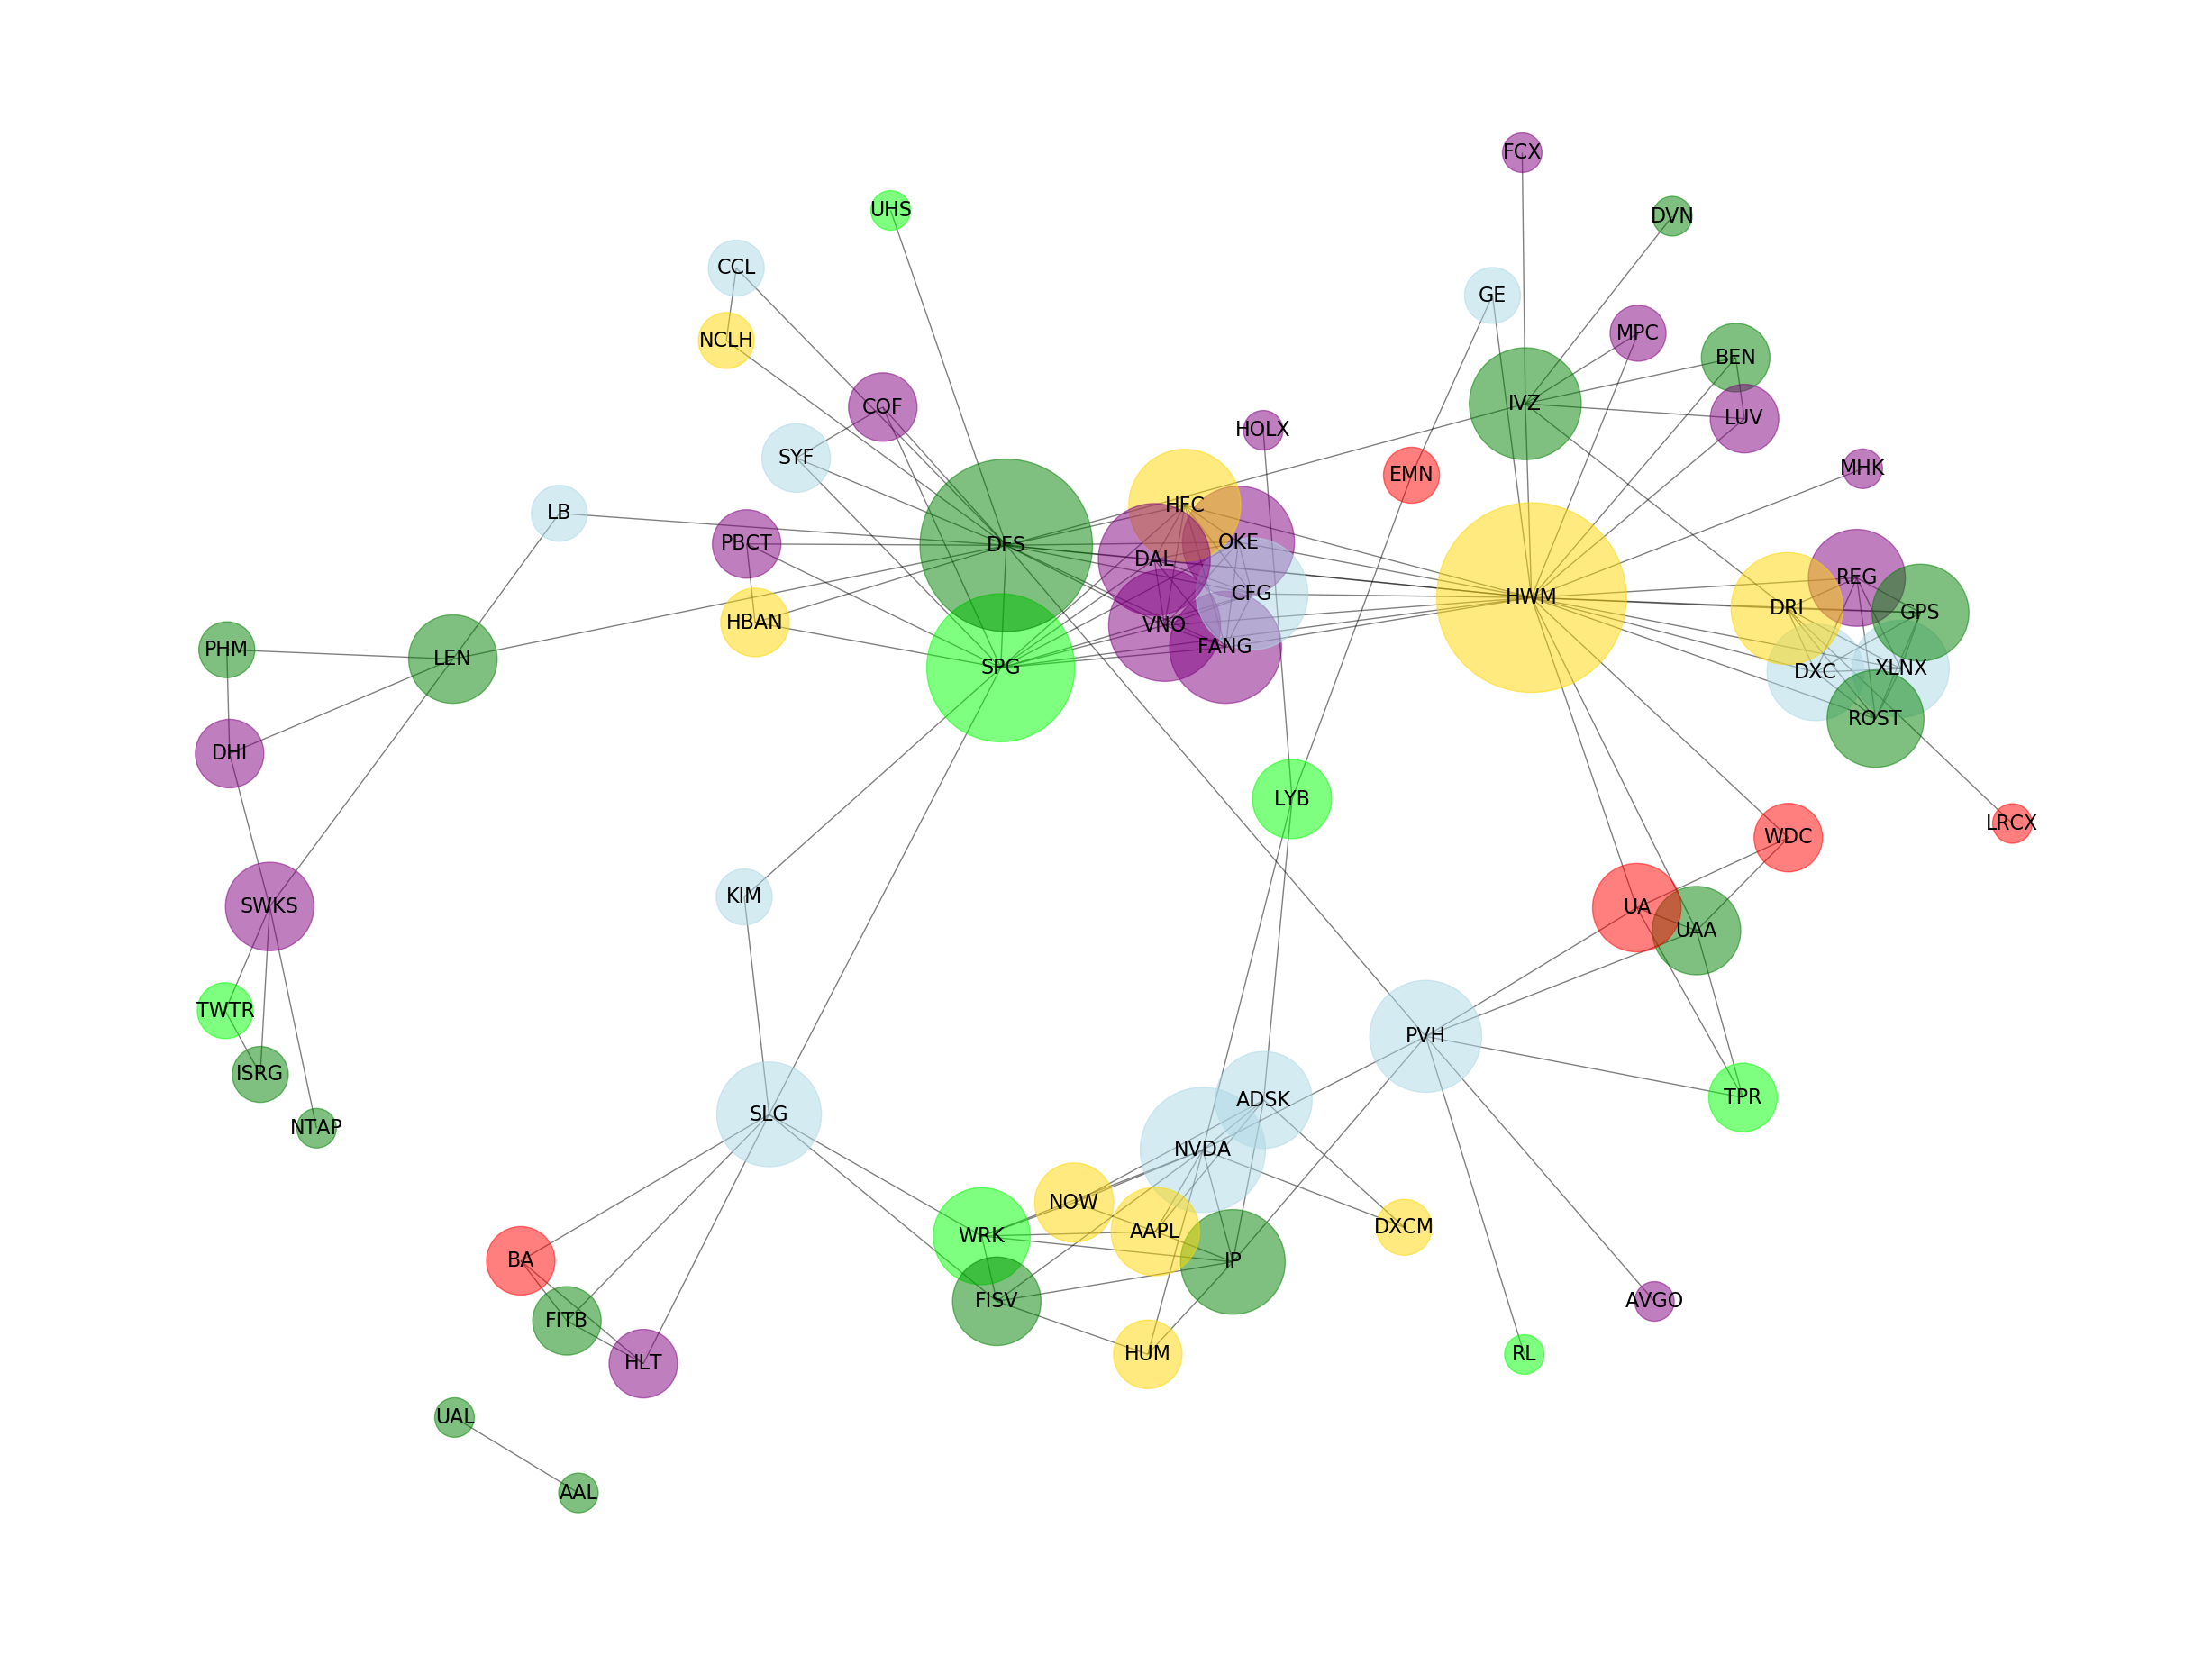

In [20]:
fig = plt.figure(figsize = (24, 18), dpi = 100, facecolor = 'w', edgecolor = 'k')

# plot based on above island method result, i.e. weight >2
pc = trim_edges(CC, 2)

CS = set(dfClean[dfClean['sector'] == "Communication Services"].iloc[:, 0].unique())
CD = set(dfClean[dfClean['sector'] == "Consumer Discretionary"].iloc[:, 0].unique())
CS2 = set(dfClean[dfClean['sector'] == "Consumer Staples"].iloc[:, 0].unique())
E = set(dfClean[dfClean['sector'] == "Energy"].iloc[:, 0].unique())
F = set(dfClean[dfClean['sector'] == "Financials"].iloc[:, 0].unique())
HC = set(dfClean[dfClean['sector'] == "Health Care"].iloc[:, 0].unique())
I = set(dfClean[dfClean['sector'] == "Industrials"].iloc[:, 0].unique())
IT = set(dfClean[dfClean['sector'] == "Information Technology"].iloc[:, 0].unique())
M = set(dfClean[dfClean['sector'] == "Materials"].iloc[:, 0].unique())
RE = set(dfClean[dfClean['sector'] == "Real Estate"].iloc[:, 0].unique())
U = set(dfClean[dfClean['sector'] == "Utilities"].iloc[:, 0].unique())

nodecolors=[]

for n in pc.degree(symbol_nodes).keys():
    if n in CD:
        nodecolors.append('green')
    elif n in IT:
        nodecolors.append('lightblue')
    elif n in F:
        nodecolors.append('gold')
    elif n in HC:
        nodecolors.append('red')
    elif n in I:
        nodecolors.append('lime')    
    else:
        nodecolors.append('purple')

dpc = pc.degree()
nx.draw(pc, node_size = [v*1000 for v in dpc.values()], 
        with_labels = True, 
        node_color = nodecolors, 
        alpha = .5, 
        font_size = 16)

In [21]:
#dpc
#CC.edges(data = True)

## Neighbors

In [22]:
for n, d in pc.nodes(data = True):
    pc.node[n]['neighbors_count'] = len(list(pc.neighbors(n)))

list(pc.nodes(data = True))

[('RL', {'neighbors_count': 1}),
 ('PVH', {'neighbors_count': 8}),
 ('ADSK', {'neighbors_count': 6}),
 ('NVDA', {'neighbors_count': 10}),
 ('LYB', {'neighbors_count': 4}),
 ('DXCM', {'neighbors_count': 2}),
 ('IP', {'neighbors_count': 7}),
 ('NOW', {'neighbors_count': 4}),
 ('AAPL', {'neighbors_count': 5}),
 ('WRK', {'neighbors_count': 6}),
 ('HUM', {'neighbors_count': 3}),
 ('FISV', {'neighbors_count': 5}),
 ('FITB', {'neighbors_count': 3}),
 ('HLT', {'neighbors_count': 3}),
 ('SLG', {'neighbors_count': 7}),
 ('BA', {'neighbors_count': 3}),
 ('OKE', {'neighbors_count': 8}),
 ('FANG', {'neighbors_count': 8}),
 ('VNO', {'neighbors_count': 8}),
 ('CFG', {'neighbors_count': 8}),
 ('HWM', {'neighbors_count': 23}),
 ('SPG', {'neighbors_count': 14}),
 ('DFS', {'neighbors_count': 19}),
 ('HFC', {'neighbors_count': 8}),
 ('DAL', {'neighbors_count': 8}),
 ('UAA', {'neighbors_count': 5}),
 ('UA', {'neighbors_count': 5}),
 ('WDC', {'neighbors_count': 3}),
 ('TPR', {'neighbors_count': 3}),
 ('HOLX

## Eigenvector centrality

In [23]:
ec = nx.eigenvector_centrality(pc)

sorted(ec.items(), key = lambda x: x[1], reverse = True)

[('HWM', 0.4005060802136448),
 ('DFS', 0.36063085796309846),
 ('SPG', 0.32365553156348376),
 ('OKE', 0.26916964398684995),
 ('FANG', 0.26916964398684995),
 ('VNO', 0.26916964398684995),
 ('CFG', 0.26916964398684995),
 ('HFC', 0.26916964398684995),
 ('DAL', 0.26916964398684995),
 ('IVZ', 0.13691708818393578),
 ('DRI', 0.11804464622053364),
 ('XLNX', 0.10309066860346495),
 ('DXC', 0.10309066860346495),
 ('REG', 0.10309066860346495),
 ('GPS', 0.10309066860346494),
 ('ROST', 0.10309066860346494),
 ('HBAN', 0.0852146259137857),
 ('PBCT', 0.0852146259137857),
 ('SYF', 0.0852146259137857),
 ('COF', 0.0852146259137857),
 ('UAA', 0.07843668949267933),
 ('UA', 0.07843668949267933),
 ('BEN', 0.06692612904094819),
 ('LUV', 0.06692612904094819),
 ('PVH', 0.06464957578390923),
 ('WDC', 0.061724840430949),
 ('NCLH', 0.060463343522449024),
 ('MPC', 0.0595146622262861),
 ('LEN', 0.050279087922978416),
 ('CCL', 0.048863930106988265),
 ('LB', 0.047360186148977204),
 ('GE', 0.044937572310317926),
 ('SLG',

In [24]:
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 16:53:31 2020

@author: arnou
"""


import networkx as nx

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline
from itertools import count
import warnings
from pyvis import network as net

warnings.filterwarnings('ignore')

stocks = pd.read_csv('https://raw.githubusercontent.com/myvioletrose/data620_team/master/project/project_2/sp500_Sep2020.csv',encoding="ISO-8859-1")

stocks2 = stocks

new_df = pd.merge(stocks, stocks2,  how='outer', left_on=['datekey','direction'], right_on = ['datekey','direction'])

new_df = new_df[(new_df.symbol_x != new_df.symbol_y)]

new_df = new_df[(new_df.direction != "Same")]

new_df["name_one_length"] = new_df['company_name_x'].str.len()
new_df["name_two_length"] = new_df['company_name_y'].str.len()

new_df['symbol_one'] = new_df['symbol_x']
new_df['symbol_two'] = new_df['symbol_y']


new_df['company_name_one'] = new_df['company_name_x']
new_df['company_name_two'] = new_df['company_name_y']

new_df['sector_one'] = new_df['sector_x']
new_df['sector_two'] = new_df['sector_y']

#####################################################################################################
new_df.loc[new_df.name_one_length > new_df.name_two_length,'symbol_one'] = new_df['symbol_x']
new_df.loc[new_df.name_one_length < new_df.name_two_length,'symbol_one'] = new_df['symbol_y']
new_df.loc[new_df.name_one_length < new_df.name_two_length,'symbol_two'] = new_df['symbol_x']
new_df.loc[new_df.name_one_length > new_df.name_two_length,'symbol_two'] = new_df['symbol_y']
#####################################################################################################
new_df.loc[new_df.name_one_length > new_df.name_two_length,'company_name_one'] = new_df['company_name_x']
new_df.loc[new_df.name_one_length < new_df.name_two_length,'company_name_one'] = new_df['company_name_y']
new_df.loc[new_df.name_one_length < new_df.name_two_length,'company_name_two'] = new_df['company_name_x']
new_df.loc[new_df.name_one_length > new_df.name_two_length,'company_name_two'] = new_df['company_name_y']
#####################################################################################################
#####################################################################################################
new_df.loc[new_df.name_one_length > new_df.name_two_length,'sector_one'] = new_df['sector_x']
new_df.loc[new_df.name_one_length < new_df.name_two_length,'sector_one'] = new_df['sector_y']
new_df.loc[new_df.name_one_length < new_df.name_two_length,'sector_two'] = new_df['sector_x']
new_df.loc[new_df.name_one_length > new_df.name_two_length,'sector_two'] = new_df['sector_y']
#####################################################################################################

new_df['sector_x'] = new_df['sector_one']
new_df['sector_y'] = new_df['sector_two']

new_df['symbol_x'] = new_df['symbol_one']
new_df['symbol_y'] = new_df['symbol_two']

new_df['company_name_x'] = new_df['company_name_one']
new_df['company_name_y'] = new_df['company_name_two']

new_df = new_df.loc[:,['datekey','symbol_x', 'symbol_y','company_name_x','company_name_y','sector_x','sector_y']]

new_df = new_df.drop_duplicates()

weights = new_df.loc[:,['symbol_x', 'symbol_y','sector_x']].groupby(['symbol_x', 'symbol_y']).count().reset_index()

weights.columns = ['symbol_x', 'symbol_y', 'freq']

new_df = new_df.loc[:,['symbol_x', 'symbol_y','company_name_x','company_name_y','sector_x','sector_y']]

new_df = new_df.drop_duplicates()


new_df= pd.merge(new_df, weights,  how='outer', left_on=['symbol_x','symbol_y'], right_on = ['symbol_x','symbol_y'])


new_df2 = new_df

maxdf = new_df2.groupby(['company_name_x'])['freq'].max()


new_df = new_df[(new_df.freq>2)]



#######################################################################################################################################################################
#######################################################################################################################################################################
#######################################################################################################################################################################


class_net = net.Network(height="1000px", width="1000px", bgcolor="#222222",font_color="white",notebook=True)
# set the physics layout of the network
class_net.barnes_hut()
#got_data = pd.read_csv("https://www.macalester.edu/~abeverid/data/stormofswords.csv")




new_df['symbol_x'] = new_df.symbol_x.astype(str)
new_df['symbol_y'] = new_df.symbol_y.astype(str)
new_df['sector_x'] = new_df.sector_x.astype(str)
new_df['sector_y'] = new_df.sector_y.astype(str)
#new_df['dept'] = new_df.dept.astype(str)
#new_df['dept_2'] = new_df.dept_2.astype(str)


sources = new_df.iloc[:,2]
targets = new_df.iloc[:,3]
weights = new_df.iloc[:,6]
source_genders = new_df.iloc[:,4]
target_genders = new_df.iloc[:,5]
#source_class = new_df.iloc[:,4]
#target_class = new_df.iloc[:,6]
edge_data = zip(sources, targets, weights,source_genders,target_genders)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    srcgen = e[3]
    targen = e[4]
    #srcclass = e[5]
    #tarclass = e[6]
    
    class_net.add_node(src, src, title=src, group = (srcgen))
    class_net.add_node(dst, dst, title=dst, group = (targen))
    class_net.add_edge(src, dst, value=w)


neighbor_map = class_net.get_adj_list()
# add neighbor data to node hover data
for node in class_net.nodes:
    node["title"] = node["group"]+ " " + node["title"] + "'s Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])
class_net.show("stocks_network_analysis.html")











